In [ ]:
!pip install pytorch_lightning
!pip install tensorboardX

In [1]:
from collections import namedtuple

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

import pytorch_lightning as pl

import tqdm
import json
import sklearn.metrics as sm

import tensorboardX as tb
import tensorflow as tf
import datetime, os

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(31337)

## Create pairs (first track, subsequent track, time)

In [10]:
DATA_DIR = "../botify/data/large/"
DATA_PATH = "../botify/data/"

In [3]:
# https://drive.google.com/drive/folders/1Nz5ZD3HKyCfncdF368Tym5ktjyFCd5Li?usp=sharing
data = pd.read_json(DATA_DIR + "data_4.json", lines=True)

In [4]:
data.head()

,message,timestamp,user,track,time,latency,recommendation,experiments
0,last,2022-06-13 11:39:37.645,4013,18934,0.02,0.000206,NaN,"{'AA': 'T1', 'COLLABORATIVE': 'T1'}"
1,next,2022-06-13 11:39:37.683,9693,29738,1.00,0.000902,3079.0,"{'AA': 'C', 'COLLABORATIVE': 'C'}"
2,next,2022-06-13 11:39:37.692,9693,3079,0.06,0.000923,20078.0,"{'AA': 'C', 'COLLABORATIVE': 'C'}"
3,next,2022-06-13 11:39:37.700,9693,20078,1.00,0.000858,12044.0,"{'AA': 'C', 'COLLABORATIVE': 'C'}"
4,next,2022-06-13 11:39:37.708,9693,12044,0.00,0.000927,37424.0,"{'AA': 'C', 'COLLABORATIVE': 'C'}"


In [5]:
Pair = namedtuple("Session", ["user", "start", "track", "time"])

def get_pairs(user_data):
    pairs = []
    first = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if first is None:
            first = row["track"]
        else:
            pairs.append(Pair(row["user"], first, row["track"], row["time"]))
        
        if row["message"] == "last":
            first = None
    return pairs

In [6]:
pairs = pd.DataFrame(
    data
    .groupby("user")
    .apply(get_pairs)
    .explode()
    .values
    .tolist(),
    columns=["user", "start", "track", "time"]
)

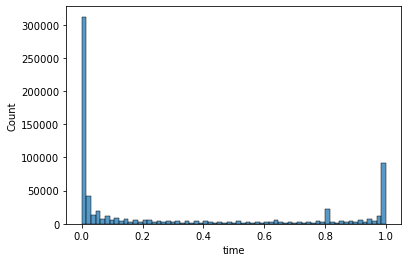

In [7]:
figure, ax = plt.subplots()
sns.histplot(pairs["time"], ax=ax)
pass

## Train Model

In [8]:
rdm = np.random.random(len(pairs))
train_data = pairs[rdm < 0.8]
val_data = pairs[(rdm >= 0.8) & (rdm < 0.9)]
test_data = pairs[rdm >= 0.9]

len(train_data), len(val_data), len(test_data)

(572587, 70915, 71742)

In [9]:
class ContextualRanker(pl.LightningModule):
    def __init__(self, embedding_dim=10):
        super().__init__()
        self.embedding_dim = embedding_dim
        
        # We won't have embeddings for everything, but that's ok
        self.context = nn.Embedding(num_embeddings=50000, embedding_dim=embedding_dim)
        self.track = nn.Embedding(num_embeddings=50000, embedding_dim=embedding_dim)

    def forward(self, x):
        context = self.context(x[:, 0])
        track = self.track(x[:, 1])
        return torch.sum(context * track, dim=1)
            
    
    def step(self, batch, batch_idx, metric, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        loss = F.mse_loss(predictions, y.float(), reduction='mean')
        self.log(metric, loss, prog_bar=prog_bar)
        return loss

    def test_step(self, batch, batch_idx, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        avgs = y[:, 0].float()
        targets = y[:, 1].float()
        rdms = y[:, 2].float()

        loss = F.mse_loss(predictions, targets, reduction='mean')
        avg_loss = F.mse_loss(avgs, targets, reduction='mean')
        rdm_loss = F.mse_loss(rdms, targets, reduction='mean')

        self.log("test_loss", loss, prog_bar=prog_bar)
        self.log("avg_loss", avg_loss, prog_bar=prog_bar)
        self.log("rdm_loss", rdm_loss, prog_bar=prog_bar)

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train_loss")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val_loss", True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'reduce_on_plateau': True,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

In [10]:
class ContextualRankerData(pl.LightningDataModule):
    def __init__(self, train_data, val_data, test_data, features):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.features = features

    def prepare_data(self):
        self.test_data = self.test_data.assign(rdm = np.random.random(len(self.test_data))).assign(avg = self.train_data["time"].mean())

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_dataset = td.TensorDataset(
                torch.from_numpy(self.train_data[self.features].values), 
                torch.from_numpy(self.train_data["time"].values)
                )

            self.val_dataset = td.TensorDataset(
                torch.from_numpy(self.val_data[self.features].values), 
                torch.from_numpy(self.val_data["time"].values)
                )

        if stage == "test" or stage is None:  
            self.test_dataset = td.TensorDataset(
                torch.from_numpy(self.test_data[self.features].values),
                torch.from_numpy(self.test_data[["time", "avg", "rdm"]].values)
            )
    def train_dataloader(self):
        return td.DataLoader(self.train_dataset, batch_size=2048, shuffle=True, num_workers=0)

    def val_dataloader(self):
        return td.DataLoader(self.val_dataset, batch_size=2048, num_workers=0)

    def test_dataloader(self):
        return td.DataLoader(self.test_dataset, batch_size=512, shuffle=False, num_workers=0)

In [11]:
net = ContextualRanker()
data_module = ContextualRankerData(train_data, val_data, test_data, features = ["start", "track"])

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss")

trainer = pl.Trainer(
    max_epochs=300,
    gpus=1, 
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=5),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback
    ])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
torch.cuda.is_available()

True

In [13]:
trainer.fit(
    net, 
    data_module
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params
--------------------------------------
0 | context | Embedding | 500 K 
1 | track   | Embedding | 500 K 
--------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\sudin\anaconda3\envs\recsys\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
C:\Users\sudin\anaconda3\envs\recsys\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00153: reducing learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00160: reducing learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [9]:
%reload_ext tensorboard
%tensorboard --logdir ./lightning_logs --host localhost

In [24]:
best = ContextualRanker.load_from_checkpoint(checkpoint_callback.best_model_path)

In [25]:
trainer.test(best, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\sudin\anaconda3\envs\recsys\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:245: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Testing: 0it [00:00, ?it/s]

─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        avg_loss            0.15447917580604553
        rdm_loss            0.12324310839176178
        test_loss           0.06625540554523468
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.06625540554523468,
  'avg_loss': 0.15447917580604553,
  'rdm_loss': 0.12324310839176178}]

## Compute top recommendations

In [27]:
track_meta = pd.read_json(DATA_PATH + "tracks.json", lines=True)

In [28]:
context_embeddings = dict(best.named_parameters())["context.weight"].data.cpu().numpy()
track_embeddings = dict(best.named_parameters())["track.weight"].data.cpu().numpy()

In [29]:
track_meta.head()

,artist,title,track
0,Jack Johnson,The Cove,0
1,Billy Preston,Nothing from Nothing,1
2,Paco De Lucia,Entre Dos Aguas,2
3,Josh Rouse,Under Cold Blue Stars,3
4,The Dead 60s,Riot Radio (Soundtrack Version),4


In [30]:
k = 10
with open(DATA_PATH + "tracks_with_recs.json", "w") as rf:
    for _, track in tqdm.tqdm(track_meta.iterrows()):
        embedding = context_embeddings[track["track"]]
        neighbours = np.argpartition(-np.dot(track_embeddings, embedding), k)[:k]
        
        recommendation = dict(track)
        recommendation["recommendations"] = neighbours.tolist()
        
        rf.write(json.dumps(recommendation) + "\n")

50000it [01:27, 572.05it/s]


In [31]:
track = 1228
embedding = context_embeddings[track]
track_meta.loc[track_meta["track"] == track, ["artist", "title"]]

,artist,title
1228,Muse,Supermassive Black Hole (Album Version)


In [32]:
k = 10
neighbours = np.argpartition(-np.dot(track_embeddings, embedding), k)[:k]
track_meta.loc[track_meta["track"].isin(neighbours), ["artist", "title"]]

,artist,title
171,OneRepublic,Secrets
178,Lil Wayne / Eminem,Drop The World
423,Cage The Elephant,Ain't No Rest For The Wicked (Original Version)
1506,Pearl Jam,Black
3357,Cage The Elephant,In One Ear
5577,OutKast,Ms. Jackson
6646,Slim Dusty,Long Black Road
9064,Audioslave,I Am The Highway
11461,Rage Against The Machine,Bulls On Parade
20675,The White Stripes,The Hardest Button To Button
